# Particle Physics Event Classificator

Accurately separating rare signal (s) events from abundant background (b) is central to particle physics.
This dataset provides reconstructed kinematic features per event, along with a per-event Weight to reflect experimental importance.
The task is binary classification: predict whether an event is signal (s) or background (b).

In [56]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, accuracy_score,
                             confusion_matrix, ConfusionMatrixDisplay, make_scorer, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pickle import dump

In [11]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/aguamelsu/particle-collision-classification/refs/heads/main/data/raw/Particle%20Physics%20Event%20Classification.csv')
df_raw.sample(10, random_state=2025)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
177817,277817,76.740,43.306,61.253,1.278,-999.000,-999.000,-999.000,2.549,1.278,...,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,4.376978,b
114117,214117,76.291,12.864,54.706,58.490,1.103,143.215,-0.270,1.748,11.717,...,2,90.305,-0.367,1.405,43.035,0.736,-2.130,133.340,2.234638,b
218727,318727,83.701,124.825,71.534,70.848,-999.000,-999.000,-999.000,1.721,27.752,...,1,51.981,0.003,-0.307,-999.000,-999.000,-999.000,51.981,2.267154,b
242708,342708,133.276,79.435,103.680,138.187,-999.000,-999.000,-999.000,1.821,10.642,...,1,132.205,-0.485,-1.640,-999.000,-999.000,-999.000,132.205,0.001503,s
78083,178083,95.130,92.170,85.114,41.222,-999.000,-999.000,-999.000,1.910,1.953,...,1,40.366,-1.652,0.230,-999.000,-999.000,-999.000,40.366,2.310104,b
113743,213743,128.881,4.445,84.894,4.079,-999.000,-999.000,-999.000,3.108,41.778,...,1,38.334,-2.637,-0.085,-999.000,-999.000,-999.000,38.334,0.001503,s
188351,288351,121.074,21.141,79.973,77.517,-999.000,-999.000,-999.000,2.289,14.580,...,1,81.565,2.014,2.716,-999.000,-999.000,-999.000,81.565,0.001503,s
165724,265724,185.240,73.543,147.203,99.234,2.597,157.718,-1.168,3.186,22.200,...,2,61.623,0.578,2.090,31.977,-2.019,3.117,93.600,3.037533,b
142400,242400,86.190,81.244,70.663,54.976,3.787,323.212,-1.932,2.073,15.443,...,2,70.642,-3.180,-0.663,31.973,0.607,1.987,102.615,2.247697,b
185228,285228,97.379,14.258,70.776,49.106,-999.000,-999.000,-999.000,2.635,49.106,...,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.681611,b


In [36]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

In [21]:
# Preprocessing
df_baking = df_raw.copy()

df_baking.columns = df_baking.columns.str.lower()

# In this dataset, values coded as -999 are refered as null
df_baking = df_baking.replace(-999, np.nan)
df_baking.isna().sum()

,0
eventid,0
der_mass_mmc,38114
der_mass_transverse_met_lep,0
der_mass_vis,0
der_pt_h,0
der_deltaeta_jet_jet,177456
der_mass_jet_jet,177457
der_prodeta_jet_jet,177457
der_deltar_tau_lep,0
der_pt_tot,0


In [22]:
# Drop columns with missing values > 30%
missing =  df_baking.isna().mean()
df_missing = missing[missing > 0.3]

display("Columns with > 30% missing values:")
display(df_missing)

'Columns with > 30% missing values:'

,0
der_deltaeta_jet_jet,0.709824
der_mass_jet_jet,0.709828
der_prodeta_jet_jet,0.709828
der_lep_eta_centrality,0.709828
pri_jet_leading_pt,0.399652
pri_jet_leading_eta,0.399652
pri_jet_leading_phi,0.399652
pri_jet_subleading_pt,0.709828
pri_jet_subleading_eta,0.709828
pri_jet_subleading_phi,0.709828


In [23]:
df_baking = df_baking.drop(columns=df_missing.index)
df_baking = df_baking.drop(columns='eventid')
df_baking = df_baking.dropna()

df_baking['label'] = df_baking['label'].astype('category')

# Fill other null columns
df_baking.fillna(df_baking.mean(numeric_only=True), inplace=True)

df = df_baking.copy()

df.sample(10, random_state=2025)

,der_mass_mmc,der_mass_transverse_met_lep,der_mass_vis,der_pt_h,der_deltar_tau_lep,der_pt_tot,der_sum_pt,der_pt_ratio_lep_tau,der_met_phi_centrality,pri_tau_pt,...,pri_lep_pt,pri_lep_eta,pri_lep_phi,pri_met,pri_met_phi,pri_met_sumet,pri_jet_num,pri_jet_all_pt,weight,label
84483,385.704,7.951,264.448,158.870,3.424,12.546,322.384,2.282,1.108,36.737,...,83.849,1.310,2.527,62.146,2.417,416.796,3,201.797,3.098498,b
160595,73.168,9.420,52.517,5.921,2.893,5.921,52.797,1.050,-1.408,25.759,...,27.038,-2.097,-0.184,0.967,2.158,121.747,0,0.000,1.681611,b
204563,159.672,112.377,69.787,76.573,2.721,60.465,181.621,2.100,1.322,23.115,...,48.531,-0.753,-1.593,79.689,0.663,300.413,2,109.974,0.001503,s
37406,131.938,35.065,87.371,37.003,3.188,19.182,116.126,0.667,1.414,50.781,...,33.856,-0.113,-1.066,42.946,-0.110,164.955,1,31.490,1.853110,b
90745,133.186,55.825,88.218,67.793,2.693,6.508,159.477,0.701,1.413,53.864,...,37.744,0.054,-1.451,43.758,0.064,339.449,1,67.870,0.001503,s
167148,172.059,66.012,143.629,24.688,3.602,24.688,67.414,0.807,-1.376,37.315,...,30.099,-2.013,-1.995,40.530,0.480,179.207,0,0.000,2.651963,b
75801,144.185,14.733,56.582,205.056,1.716,46.551,343.329,1.046,0.098,28.585,...,29.900,-1.887,0.464,147.481,0.686,365.416,2,284.843,0.001503,s
87013,121.306,25.609,89.452,44.551,2.695,44.551,95.665,1.813,1.410,34.006,...,61.659,-0.388,1.459,11.516,0.456,106.582,0,0.000,4.671127,b
197893,130.883,4.548,93.410,11.202,3.771,11.202,53.044,1.000,-1.260,26.522,...,26.521,-1.783,-0.891,10.999,-1.158,129.333,0,0.000,0.018636,s
126466,101.521,8.342,72.643,63.581,2.744,1.421,143.884,2.762,1.281,21.602,...,59.669,2.085,-2.285,22.286,-2.515,184.912,1,62.613,1.681611,b


In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
der_mass_mmc,211886.0,121.858528,57.298157,9.044000,91.885250,112.406000,135.482000,1192.026000
der_mass_transverse_met_lep,211886.0,42.001020,30.825474,0.000000,15.751000,37.649000,63.349500,594.287000
der_mass_vis,211886.0,82.305844,39.039936,7.120000,61.290000,74.791500,92.455500,959.601000
der_pt_h,211886.0,63.228131,65.765518,0.000000,20.710000,43.582000,86.432500,2834.999000
der_deltar_tau_lep,211886.0,2.430013,0.765918,0.224000,1.898000,2.575000,2.993000,5.684000
der_pt_tot,211886.0,19.338716,21.907415,0.000000,3.045000,14.331000,28.085000,2834.999000
der_sum_pt,211886.0,167.645039,119.000718,46.104000,84.118000,130.873000,212.286750,1852.462000
der_pt_ratio_lep_tau,211886.0,1.428344,0.859173,0.047000,0.859000,1.259000,1.776000,19.773000
der_met_phi_centrality,211886.0,0.053725,1.191099,-1.414000,-1.346000,0.315000,1.293000,1.414000
pri_tau_pt,211886.0,39.657081,22.870225,20.000000,25.116000,32.844000,46.313000,622.862000


It seems there aren't many outliers in the data since the std and the mean are relatively close. Further inspection is needed, but at first glance this dataset won't need any transformations if an XGB or RandomForest model is trained (which probably will). Otherwise this data should be at least scaled since there are features such as pri_met, der_pt_tot, etc. that go up to a thousand, while other features range in much lower values.

In [27]:
# EDA
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=2025)
df_train, df_val = train_test_split(df_train, test_size=0.1, stratify=df_train['label'], random_state=2025)

# Reset index
# df_train = df_train.reset_index(drop=True)
# df_val = df_val.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

df_train.shape, df_test.shape, df_val.shape

((152557, 22), (42378, 22), (16951, 22))

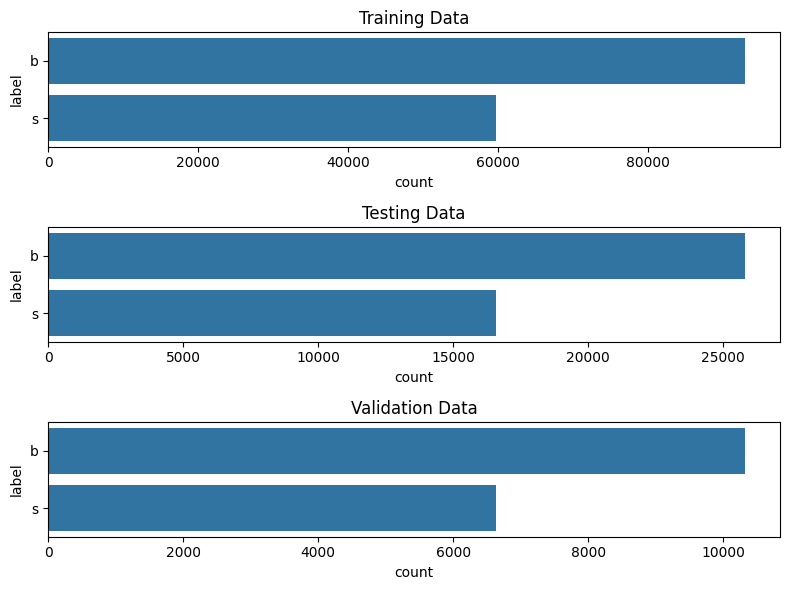

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

sns.countplot(data=df_train, y='label', ax=ax[0])
sns.countplot(data=df_test, y='label', ax=ax[1])
sns.countplot(data=df_val, y='label', ax=ax[2])

ax[0].set_title('Training Data')
ax[1].set_title('Testing Data')
ax[2].set_title('Validation Data')

plt.tight_layout()
plt.show()

PRI_ $\rightarrow$ Primary measurements. Raw measurements taken directly from the particle accelerator.

DER_ $\rightarrow$ Derived measurements. Derived measurements physicists reconstruct to better represent patterns.

For the purpose of this work, both types of measurements will be used, but the EDA will be performed separately to avoid dropping due to colinearity issues.

In [29]:
# Group by primary feature or derived feature from experiment
primary = [c for c in df_train.columns if c.startswith('pri_')]
derived = [c for c in df_train.columns if c.startswith('der_')]

primary.append('label')
derived.append('label')

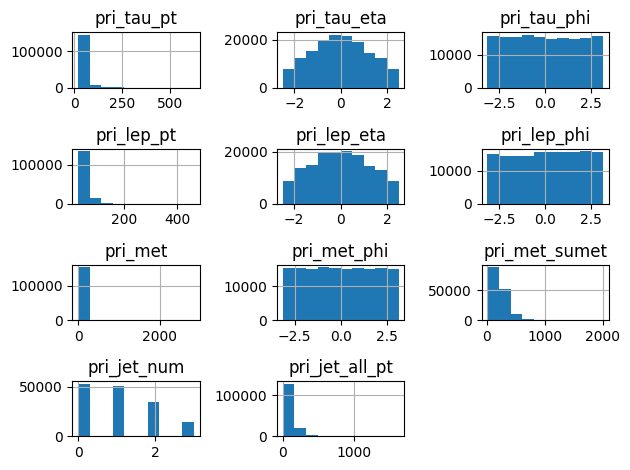

In [30]:
df_train[primary].hist()
plt.tight_layout()
plt.show()

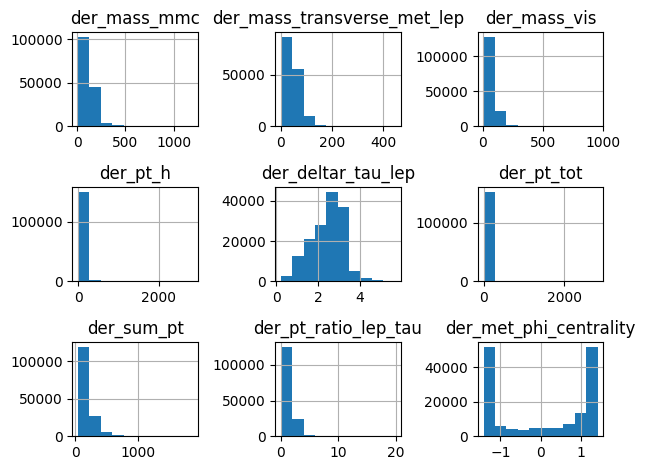

In [31]:
df_train[derived].hist()
plt.tight_layout()
plt.show()

In [32]:
X_train = df_train.drop(columns='label')
X_test = df_test.drop(columns='label')
X_val = df_val.drop(columns='label')

y_train = df_train['label']
y_test = df_test['label']
y_val = df_val['label']

In [33]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_val_enc = le.transform(y_val)

In [34]:
def display_metrics(y_hat, y_test, name):
    print(f'Accuracy score: {accuracy_score(y_hat, y_test)}')
    print(classification_report(y_hat, y_test))

    cm = confusion_matrix(y_hat, y_test, labels=[True, False])
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)

    disp.plot()
    plt.title(f'Confusion matrix for {name}')
    plt.show()

In [35]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train_enc)

RandomForestClassifier()

Accuracy score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10324
           1       1.00      1.00      1.00      6627

    accuracy                           1.00     16951
   macro avg       1.00      1.00      1.00     16951
weighted avg       1.00      1.00      1.00     16951



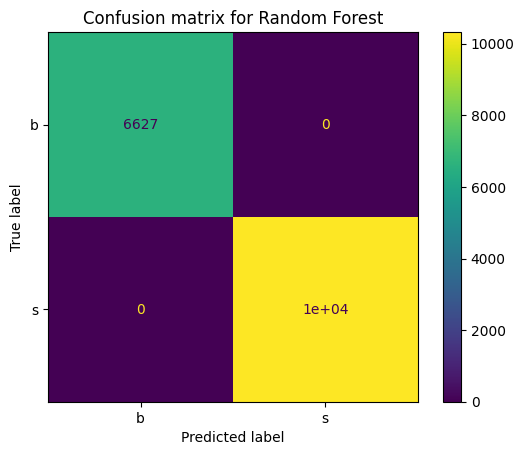

In [39]:
y_hat_val = rf.predict(X_val)
display_metrics(y_hat_val, y_val_enc, 'Random Forest')

This Random Forest model got an accuracy of 100%. This doesn't mean it was a powerful or even robust model. The model wasn't even given any hyperparameters to tune it, thus this probably means a data leakage. The next few cells will confirm if there is any data leakage and if so, its solution.

In [53]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

                        Feature  Importance
20                       weight    0.785101
0                  der_mass_mmc    0.064491
1   der_mass_transverse_met_lep    0.038482
2                  der_mass_vis    0.027745
7          der_pt_ratio_lep_tau    0.016192
9                    pri_tau_pt    0.015609
8        der_met_phi_centrality    0.012973
4            der_deltar_tau_lep    0.007910
3                      der_pt_h    0.005756
15                      pri_met    0.004558


In [55]:
# Analyzing data leakage
df = X_train.copy()
df['target'] = y_train_enc

leak_scores = []
for col in X_train.columns:
    try:
        auc = roc_auc_score(df['target'], df[col])
        leak_scores.append((col, auc))
    except Exception:
        pass

leak_df = pd.DataFrame(leak_scores, columns=['Feature','AUC']).sort_values('AUC', ascending=False)
print(leak_df.head(10))

                   Feature       AUC
9               pri_tau_pt  0.677486
0             der_mass_mmc  0.635997
8   der_met_phi_centrality  0.609028
6               der_sum_pt  0.592286
3                 der_pt_h  0.589622
19          pri_jet_all_pt  0.579548
2             der_mass_vis  0.572918
17           pri_met_sumet  0.572907
18             pri_jet_num  0.558127
15                 pri_met  0.511963


In [56]:
train_hash = pd.util.hash_pandas_object(X_train.round(6), index=False)
val_hash   = pd.util.hash_pandas_object(X_val.round(6), index=False)

common = set(train_hash).intersection(set(val_hash))
print(f"Exact overlapping rows after cleaning: {len(common)}")

Exact overlapping rows after cleaning: 0


In [59]:
y_shuffled = np.random.permutation(y_train_enc)
print('Permutation completed')
rf.fit(X_train, y_shuffled)
print('Training completed')
pred = rf.predict(X_val)
print("Accuracy with shuffled labels:", accuracy_score(y_val_enc, pred))

Permutation completed
Training completed
Accuracy with shuffled labels: 0.5956660243048728


In [62]:
print(len(X_val) == len(y_val_enc))


True


This seems normal. To differentiate the model, only derived quantities will be predicted, then only primary quantities, and after this models will be compared

In [37]:
df_der = df[derived]
df_der['weight'] = df['weight']
df_der['label'] = df['label']

df_train_der, df_test_der = train_test_split(df_der, test_size=0.2, stratify=df_der['label'], random_state=2025)
df_train_der, df_val_der = train_test_split(df_train_der, test_size=0.1, stratify=df_train_der['label'], random_state=2025)

X_train_der = df_train_der.drop(columns='label')
X_test_der = df_test_der.drop(columns='label')
X_val_der = df_val_der.drop(columns='label')

y_train_der = df_train_der['label']
y_test_der = df_test_der['label']
y_val_der = df_val_der['label']

/tmp/ipython-input-1270027434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_der['weight'] = df['weight']
/tmp/ipython-input-1270027434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_der['label'] = df['label']


In [38]:
le = LabelEncoder()

y_train_der_enc = le.fit_transform(y_train_der)
y_test_der_enc = le.transform(y_test_der)
y_val_der_enc = le.transform(y_val_der)

In [52]:
rf_der = RandomForestClassifier()
rf_der.fit(X_train_der, y_train_der_enc)

RandomForestClassifier()

Accuracy score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10324
           1       1.00      1.00      1.00      6627

    accuracy                           1.00     16951
   macro avg       1.00      1.00      1.00     16951
weighted avg       1.00      1.00      1.00     16951



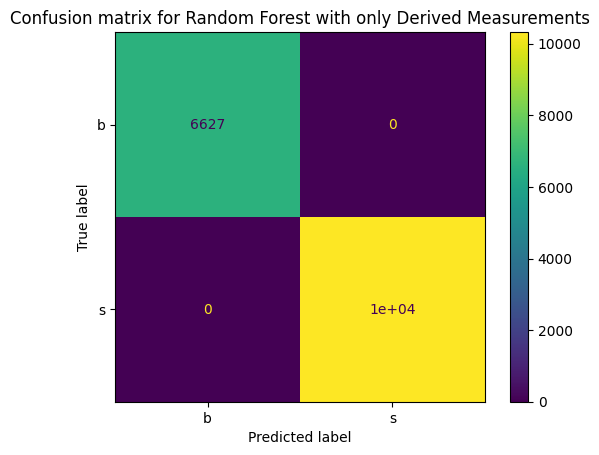

In [54]:
y_hat_der_val = rf_der.predict(X_val_der)
display_metrics(y_hat_der_val, y_val_der_enc, 'Random Forest with only Derived Measurements')

Model with primary measurements

In [45]:
df_pri = df[primary]
df_pri['weight'] = df['weight']
df_pri['label'] = df['label']

df_train_pri, df_test_pri = train_test_split(df_pri, test_size=0.2, stratify=df_pri['label'], random_state=2025)
df_train_pri, df_val_pri = train_test_split(df_train_pri, test_size=0.1, stratify=df_train_pri['label'], random_state=2025)

X_train_pri = df_train_pri.drop(columns='label')
X_test_pri = df_test_pri.drop(columns='label')
X_val_pri = df_val_pri.drop(columns='label')

y_train_pri = df_train_pri['label']
y_test_pri = df_test_pri['label']
y_val_pri = df_val_pri['label']

/tmp/ipython-input-1428983033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pri['weight'] = df['weight']
/tmp/ipython-input-1428983033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pri['label'] = df['label']


In [46]:
le = LabelEncoder()

y_train_pri_enc = le.fit_transform(y_train_pri)
y_test_pri_enc = le.transform(y_test_pri)
y_val_pri_enc = le.transform(y_val_pri)

In [53]:
rf_pri = RandomForestClassifier()
rf_pri.fit(X_train_pri, y_train_pri_enc)

RandomForestClassifier()

Accuracy score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10324
           1       1.00      1.00      1.00      6627

    accuracy                           1.00     16951
   macro avg       1.00      1.00      1.00     16951
weighted avg       1.00      1.00      1.00     16951



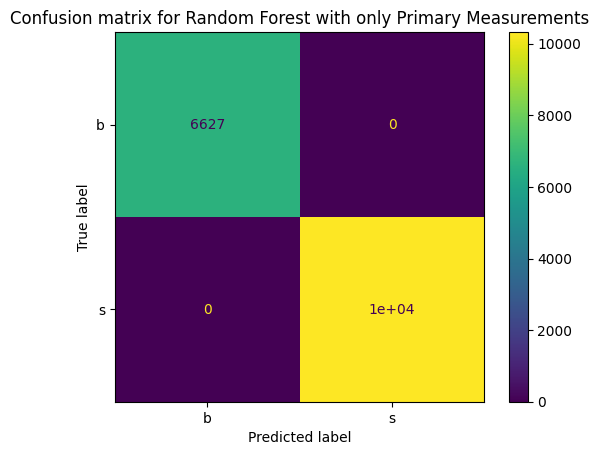

In [55]:
y_hat_pri_val = rf.predict(X_val_pri)
display_metrics(y_hat_pri_val, y_val_pri_enc, 'Random Forest with only Primary Measurements')

In [59]:
# Dataset
df_train.to_csv('/content/proc_data/df_train.csv', index=False)
df_test.to_csv('/content/proc_data/df_test.csv', index=False)
df_val.to_csv('/content/proc_data/df_val.csv', index=False)

# Derived dataset
df_train_der.to_csv('/content/proc_data/df_train_der.csv', index=False)
df_test_der.to_csv('/content/proc_data/df_test_der.csv', index=False)
df_val_der.to_csv('/content/proc_data/df_val_der.csv', index=False)

# Primary dataset
df_train_pri.to_csv('/content/proc_data/df_train_pri.csv', index=False)
df_test_pri.to_csv('/content/proc_data/df_test_pri.csv', index=False)
df_val_pri.to_csv('/content/proc_data/df_val_pri.csv', index=False)

In [60]:
# Save models
dump(rf, open('models/rf', 'wb'))
dump(rf_der, open('models/rf_der', 'wb'))
dump(rf_pri, open('models/rf_pri', 'wb'))
